# Project 3: Airbnb
**This is the third of three mandatory projects to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The project is to be done in groups of at most 3 students**
- **Each group has to hand in _one_ Jupyter notebook (this notebook) with their solution**
- **The hand-in of the notebook is due 2019-12-05, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python/PySpark**
- **For each question you may use as many cells for your solution as you like**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**
- **You are not expected to use machine learning to solve any of the exercises**

# Introduction
[Airbnb](http://airbnb.com) is an online marketplace for arranging or offering lodgings. In this project you will use Spark to analyze data obtained from the Airbnb website. The purpose of the analysis is to extract information about trends and patterns from the data.

The project has two parts.

### Part 1: Loading, describing and preparing the data
There's quite a lot of data. Make sure that you can load and correctly parse the data, and that you understand what the dataset contains. You should also prepare the data for the analysis in part two. This means cleaning it and staging it so that subsequent queries are fast.

### Par 2: Analysis
In this part your goal is to learn about trends and usage patterns from the data. You should give solutions to the tasks defined in this notebook, and you should use Spark to do the data processing. You may use other libraries like for instance Pandas and matplotlib for visualisation.

## Guidelines
- Processing data should be done using Spark. Once data has been reduced to aggregate form, you may use collect to extract it into Python for visualisation.
- Your solutions will be evaluated by correctness, code quality and interpretability of the output. This means that you have to write clean and efficient Spark code that will generate sensible execution plans, and that the tables and visualisations that you produce are meaningful and easy to read.
- You may add more cells for your solutions, but you should not modify the notebook otherwise.

### Create Spark session and define imports

In [1]:
from pyspark.sql import *
from pyspark.sql import functions as f
from pyspark.sql.types import *

spark = SparkSession.builder.appName("SparkIntro").getOrCreate()

# Part 1: Loading, describing and preparing the data
The data comes in two files. Start by downloading the files and putting them in your `data/` folder.

- [Listings](https://files.dtu.dk/u/siPzAasj8w2gI_ME/listings.csv?l) (5 GB)
- [Reviews](https://files.dtu.dk/u/k3oaPYp6GjKBeho4/reviews.csv?l) (9.5 GB)

### Load the data
The data has multiline rows (rows that span multiple lines in the file). To correctly parse these you should use the `multiline` option and set the `escape` character to be `"`.

In [3]:
# remove rows that has bad values (just discard)
# engineer to improve data
df = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape','"').csv('../data/listings_sub_10000.csv')
#df.groupBy('Pclass').agg(f.sum('Fare'), f.avg('Fare'), f.max('Fare')).show()
#df = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape','"').csv(spark.read.option('delimitter', ",").option('multiline', True).option('escape','"').text('data/listings.csv').limit(20).rdd.flatMap(lambda x: x))


In [4]:
df_review = spark.read.option('header', True).option('inferSchema', True).option('multiline', True).option('escape','"').csv('../data/reviews_sub_10000.csv')

### Describe the data
List the features (schema) and sizes of the datasets.

In [ ]:
df.printSchema()

In [ ]:
from functools import reduce
test = df.where(reduce(lambda x, y: x & y,  (f.col(x) != 'null' for x in df.columns)))

### Prepare the data for analysis
You should prepare two dataframes to be used in the analysis part of the project. You should not be concerned with cleaning the data. There's a lot of it, so it will be sufficient to drop rows that have bad values. You may want to go back and refine this step at a later point when doing the analysis.

You may also want to consider if you can stage your data so that subsequent processing is more efficient (this is not strictly necessary for Spark to run, but you may be able to decrease the time you sit around waiting for Spark to finish things)

In [87]:
dfp = df.toPandas()

In [153]:
dfp.isna().sum().sort_values().head(20)

_c0                                            0
maximum_minimum_nights                         0
minimum_minimum_nights                         0
maximum_nights                                 0
minimum_nights                                 0
extra_people                                   0
guests_included                                0
price                                          0
amenities                                      0
bed_type                                       0
accommodates                                   0
calculated_host_listings_count_shared_rooms    0
property_type                                  0
is_location_exact                              0
longitude                                      0
latitude                                       0
country                                        0
country_code                                   0
minimum_maximum_nights                         0
maximum_maximum_nights                         0
dtype: int64

# Part 2: Analysis
Use Spark and your favorite tool for data visualization to solve the following tasks.

## The basics
Compute and show a dataframe with the number of listings and neighbourhoods per city.

In [247]:
df.groupby('city').agg(f.count('_c0').alias('Listings'), f.countDistinct('neighbourhood').alias('Neighbourhoods')).orderBy(f.desc('Neighbourhoods')).show()

+------------------+--------+--------------+
|              city|Listings|Neighbourhoods|
+------------------+--------+--------------+
|         Stockholm|    4297|            14|
|              Oslo|    2227|            14|
|        Stockholm |      27|             9|
|              null|      13|             7|
|       Kungsholmen|     360|             5|
|  Stockholm County|       7|             5|
|         Södermalm|     845|             4|
|      Oslo kommune|       6|             3|
|         Östermalm|     267|             3|
|Hässelby-Vällingby|      92|             2|
|            Bromma|     182|             2|
|        斯德哥尔摩|       3|             2|
|         Estocolmo|       3|             2|
|         Hägersten|      13|             2|
|            Farsta|      80|             2|
|            Älvsjö|      89|             2|
|      Enskededalen|      21|             2|
|       Johanneshov|       7|             2|
|         Stoccolma|       2|             2|
|           Ens

Based on the table above, you should choose a city that you want to continue your analysis for. The city should have mulitple neighbourhoods with listings in them.

Compute and visualize the number of listings of different property types per neighbourhood in your city.

In [109]:
prop_neigh_city = df.filter(f.col('city')=='Stockholm').groupby('property_type','neighbourhood').agg(f.count('_c0')).toPandas()

In [115]:
import matplotlib.pyplot as plt
import pandas as pd

In [249]:
prop_neigh_city.head()

,property_type,neighbourhood,count(_c0)
0,Apartment,Farsta,62
1,Villa,Spånga-Tensta,1
2,Cabin,Hägersten-Liljeholmen,1
3,Townhouse,Skarpnäck,10
4,Villa,Hässelby-Vällingby,3


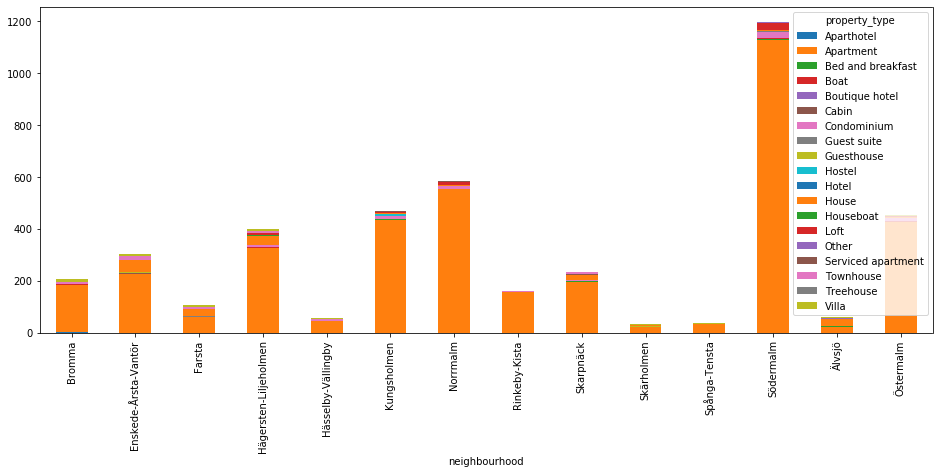

In [8]:
prop_neigh_city.pivot(index='neighbourhood',columns='property_type',\
                      values='count(_c0)').plot(kind='bar',figsize=(16,6),stacked=True)
plt.show()

## Prices
Compute the minimum, maximum and average listing price in your city. 

In [8]:
city = "Stockholm"

In [9]:
df_s = df.filter(f.col("city")==city)

In [10]:
df_s.count()

4297

In [11]:
#df_s.price = df_s.price.cast('float')

In [12]:
from pyspark.sql.types import *

In [13]:
from pyspark.sql.functions import substring, length, col, expr
df_s = df_s.withColumn("price",expr("substring(price, 2, length(price))"))

In [14]:
from  pyspark.sql.functions import regexp_replace,col

In [15]:
df_s = df_s.withColumn("price", regexp_replace(f.col("price"), ",", ""))

In [ ]:
#df_s.show()

In [ ]:
#df_s.select(df_s.price.cast("float").alias('price_new')).collect()

In [16]:
from pyspark.sql.types import *
df_d = df_s.withColumn("price",df_s["price"].cast(DoubleType()))

In [17]:
#df_d.show()

In [23]:
print("Basic statistics for", city)
df_d.select(f.avg('price').alias("Averge price"), f.max('price').alias("Max price"), f.min('price').alias("Min price")).show()

Basic statistics for Stockholm
+------------------+---------+---------+
|      Averge price|Max price|Min price|
+------------------+---------+---------+
|1104.4123807307424|  22463.0|     98.0|
+------------------+---------+---------+



Compute and visualize the distribution of listing prices in your city.

In [27]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
sns.set(rc={'figure.figsize':(16,6)})

In [25]:
df_city_p = df_d.toPandas()

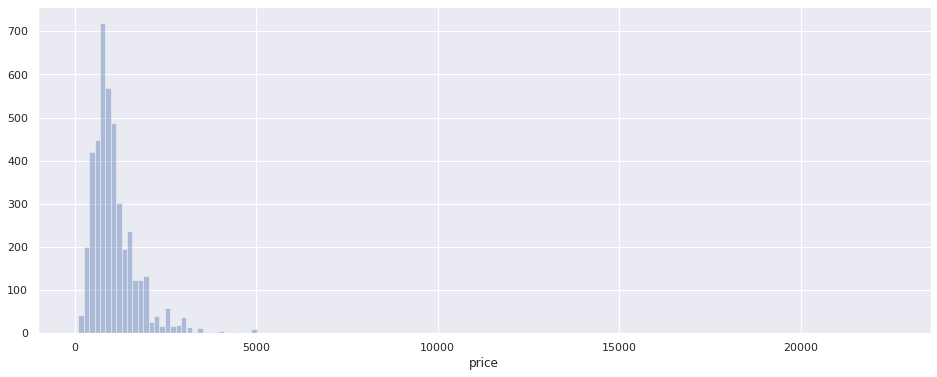

In [28]:
sns.distplot(df_city_p.price, kde=False, rug=False, bins=150);

The value of a listing is its rating divided by its price.

Compute and show a dataframe with the 3 highest valued listings in each neighbourhood.

In [29]:
from pyspark.sql.functions import lit

In [30]:
df_d = df_d.withColumn("review_scores_rating",df_s["review_scores_rating"].cast(DoubleType()))

In [31]:
df_d = df_d.withColumn("value_listing",lit(f.col("review_scores_rating")/f.col("price")))

In [32]:
df_value = df_d.select(f.col("city"),f.col("neighbourhood"),(f.col("value_listing")))

In [33]:
#df_value.orderBy(df_value.value_listing.desc()).show()

In [34]:
sorted_by_value = Window.partitionBy('neighbourhood').orderBy(f.desc('value_listing'))

In [35]:
ranked_by_value = df_d.withColumn('value_listing_rank', f.rank().over(sorted_by_value))

In [36]:
ranked_df = ranked_by_value.filter(f.col('value_listing_rank') <= 3).drop('value_listing_rank').orderBy('neighbourhood', f.desc('value_listing'))

In [37]:
ranked_df.select(f.col("neighbourhood"),f.col("value_listing"),f.col("city"),f.col("name")).show(50)

+--------------------+-------------------+---------+--------------------+
|       neighbourhood|      value_listing|     city|                name|
+--------------------+-------------------+---------+--------------------+
|              Bromma| 0.7948717948717948|Stockholm| Nice room in Bromma|
|              Bromma| 0.4444444444444444|Stockholm|        Balla Bromma|
|              Bromma|              0.375|Stockholm|Rent a room in St...|
|Enskede-Årsta-Vantör| 0.6802721088435374|Stockholm|Shared room for F...|
|Enskede-Årsta-Vantör| 0.5102040816326531|Stockholm|Cosy 50th style a...|
|Enskede-Årsta-Vantör|0.47959183673469385|Stockholm|Bekväm lägenhet i...|
|              Farsta|0.47804878048780486|Stockholm|Private room in c...|
|              Farsta|0.38188976377952755|Stockholm|Cozy Nice Room Wi...|
|              Farsta|0.35826771653543305|Stockholm|Rum uthyres i Far...|
|Hägersten-Liljeho...| 0.4266666666666667|Stockholm|Warm big room wit...|
|Hägersten-Liljeho...|0.36742424242424

## Trends
Now we want to analyze the "popularity" of your city. The data does not contain the number of bookings per listing, but we have a large number of reviews, and we will assume that this is a good indicator of activity on listings.

Compute and visualize the popularity (i.e., number of reviews) of your city over time.

In [70]:
df_review.show()

+----------+---------+-------------------+-----------+
|listing_id|review_id|               date|reviewer_id|
+----------+---------+-------------------+-----------+
|    145320|156423122|2017-05-30 00:00:00|  123386382|
|    145320|170211906|2017-07-15 00:00:00|  123091743|
|    145320|172169175|2017-07-20 00:00:00|      78004|
|    145320|176647581|2017-07-31 00:00:00|  103178743|
|    145320|185676021|2017-08-22 00:00:00|    4023961|
|    145320|189668224|2017-09-02 00:00:00|  142869362|
|    145320|191894030|2017-09-09 00:00:00|   25194419|
|    145320|193316070|2017-09-13 00:00:00|   52056015|
|    145320|196760607|2017-09-24 00:00:00|    3980456|
|    145320|201885633|2017-10-09 00:00:00|   72139946|
|    145320|203410181|2017-10-15 00:00:00|   23002655|
|    145320|210619953|2017-11-10 00:00:00|    3451329|
|    145320|211523951|2017-11-13 00:00:00|  105945750|
|    145320|212932349|2017-11-19 00:00:00|     203826|
|    145320|214018139|2017-11-24 00:00:00|   70756436|
|    14532

In [110]:
df_stockholm = df.filter(f.col('city')=='Stockholm').select('city','neighbourhood','id')
df_review = df_review.select('listing_id', 'reviewer_id', f.col('id').alias('review_id'),\
                             'date', f.year("date").alias('year'), f.month("date").alias('month'))

In [120]:
df_join = df_stockholm.join(df_review, (df_stockholm.id == df_review.listing_id), how='left')
df_plot = df_join.groupby('date').agg(f.count('review_id')).toPandas()

In [135]:
df_plot['newDate'] = pd.to_datetime(df_plot.date.dt.strftime('%Y %m'))
df_plot_newdate = df_plot.groupby('newDate').sum()

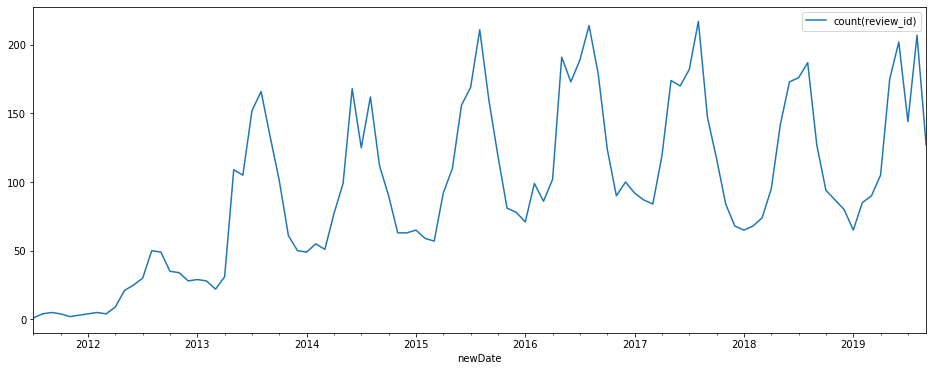

In [138]:
df_plot_newdate.plot(figsize=(16,6))
plt.show()

Compute and visualize the popularity of neighbourhoods over time. If there are many neighbourhoods in your city, you should select a few interesting ones for comparison.

In [158]:
df_plot = df_join.groupby('date','neighbourhood').agg(f.count('review_id')).toPandas()

In [159]:
df_plot['newDate'] = pd.to_datetime(df_plot.date.dt.strftime('%Y %m'))
df_plot_newdate = df_plot.groupby(['newDate','neighbourhood'], as_index=False).sum()

In [166]:
df_plot = df_plot_newdate.pivot(index='newDate',columns='neighbourhood',\
                      values='count(review_id)')
df_plot = df_plot[df_plot.index.notnull()].reset_index()
df_plot = df_plot.fillna(0)

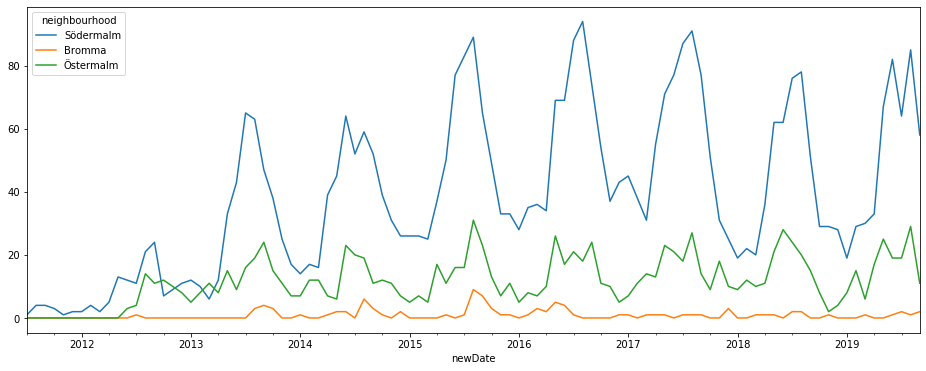

In [181]:
df_plot.plot(x='newDate', y=['Södermalm','Bromma','Östermalm'],figsize=(16,6))
plt.show()

Compute and visualize the popularity of your city by season. For example, visualize the popularity of your city per month.

In [182]:
df_plot = df_join.groupby('date').agg(f.count('review_id')).toPandas()

In [189]:
df_plot['newDate'] = pd.to_datetime(df_plot.date.dt.strftime('%m'),format='%m' )
df_plot_newdate = df_plot.groupby('newDate', as_index=False).sum()

In [195]:
import matplotlib.dates as mdates

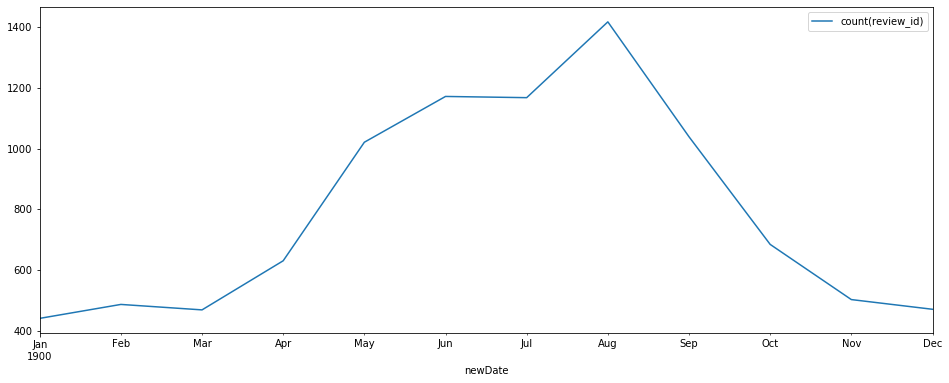

In [199]:
fig = df_plot_newdate.plot(x='newDate', y='count(review_id)',figsize=(16,6))
fig.format_xdata = mdates.DateFormatter('%Y-%m-%d')
plt.show()

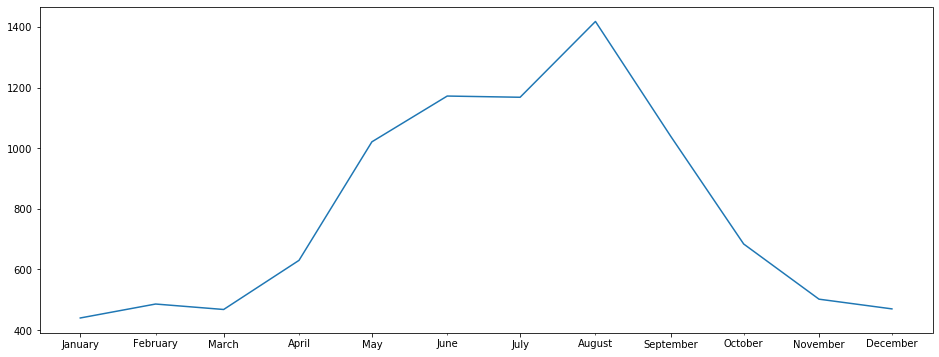

In [218]:
fig, ax = plt.subplots(figsize=(16,6))

ax.plot(df_plot_newdate.newDate, df_plot_newdate['count(review_id)'])
#ax.xaxis.
ax.set_xticks(df_plot_newdate.newDate, minor=True)
ax.xaxis.set_major_formatter(mdates.DateFormatter("%B"))
ax.xaxis.set_minor_formatter(mdates.DateFormatter("%B"))

## Reviews
In this part you should determine which words used in reviews that are the most positive. 

The individual reviews do not have a rating of the listing, so we will assume that each review gave the average rating to the listing, i.e., the one on the listing.

You should assign a positivity weight to each word seen in reviews and list the words with the highest weight. It is up to you to decide what the weight should be. For example, it can be a function of the rating on the listing on which it occurs, the number of reviews it occurs in, and the number of unique listings for which it was used to review.

Depending on your choice of weight function, you may also want to do some filtering of words. For example, remove words that only occur in a few reviews.

In [ ]:
import itertools
import csv

entries = []
with open('/home/jovyan/work/Project3/reviews.csv', 'r') as f:
    mycsv = csv.reader(f)
    for row in itertools.islice(mycsv, 10000):
        entries.append(row)
        
import pandas as pd
columns_ = entries[0]
df = pd.DataFrame(entries,columns=columns_)
df = df.iloc[1:-1,:]
#df.head()
#df.to_csv("reviews_sub_10000.csv")

In [38]:
r = pd.read_csv("reviews_sub_10000.csv")
l = pd.read_csv("listings_sub_10000.csv")

/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (1,3,16,17,19,20,28,33,34,41,49,50,54,55,56,57,60,66,68,69,70,71,72,73,74,75,78,79,80,81,83,84,87,88,89,90,91,92,93,95,96,102,103,104,105,106) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [39]:
r.head()

,Unnamed: 0,listing_id,id,date,reviewer_id,reviewer_name,comments
0,1,145320,156423122,2017-05-30,123386382,Erwin,Prima plek om Stockholm te bekijken. Alles is ...
1,2,145320,170211906,2017-07-15,123091743,Anne,Cosy and clean flat in quiet neighbourhood clo...
2,3,145320,172169175,2017-07-20,78004,Patricia,The host canceled this reservation 37 days bef...
3,4,145320,176647581,2017-07-31,103178743,Charlotte,Kim's place was outstanding and comfortable. W...
4,5,145320,185676021,2017-08-22,4023961,Alexander,great spacious apartment in a nice residential...


In [40]:
l.head()

,Unnamed: 0,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,...,instant_bookable,is_business_travel_ready,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1,145320,https://www.airbnb.com/rooms/145320,20190928160308,2019-09-28,In the middle of it all - with a view!,"Mitt boende passar par, kompisar och ensamäven...",A cozy three room flat with great personality....,"Mitt boende passar par, kompisar och ensamäven...",none,...,t,f,strict_14_with_grace_period,f,f,1,0,1,0,2.54
1,2,155220,https://www.airbnb.com/rooms/155220,20190928160308,2019-09-28,"Stockholm, new spacoius villa",Convenient and spacy home full of positive ene...,ABOUT THE HOUSE: Modern villa built in 2010. L...,ABOUT THE HOUSE: Modern villa built in 2010. L...,none,...,f,f,moderate,f,f,2,2,0,0,NaN
2,3,155685,https://www.airbnb.com/rooms/155685,20190928160308,2019-09-28,Hornstull with water view!,This apartment is located in the center of fun...,"46 sqm apartment in Hornstulls, Södermalm Stoc...",This apartment is located in the center of fun...,none,...,f,f,moderate,f,f,1,1,0,0,0.22
3,4,164448,https://www.airbnb.com/rooms/164448,20190928160308,2019-09-28,Double room in central Stockholm with Wi-Fi,I am renting out a nice double room on the top...,ROOM: The room has a twin/double bed (2x90x200...,I am renting out a nice double room on the top...,none,...,t,f,flexible,t,t,2,0,2,0,3.13
4,5,170651,https://www.airbnb.com/rooms/170651,20190928160308,2019-09-28,Petit Charm Rooftop next to heaven,NaN,"Welcome to this beautiful, small, and charming...","Welcome to this beautiful, small, and charming...",none,...,f,f,strict_14_with_grace_period,f,f,1,1,0,0,0.33


From the listings we need to:
- calculate the average rating for each ID
- join the average rating on to the ratings

In [2]:
dfl = spark.read.option("delimiter",",").option("multiline",True).option("header", True).option("escape",'"').option("inferSchema",True).csv('listings_sub_10000.csv')

In [3]:
dfr = spark.read.option("delimiter",",").option("multiline",True).option("header", True).option("escape",'"').option("inferSchema",True).csv('reviews_sub_10000.csv')

In [47]:
mean_scores = dfl.groupBy("id").agg(f.mean("review_scores_rating").alias("average_rating"))

In [45]:
spark.conf.set("spark.sql.autoBroadcastJoinThreshold", -1)

In [48]:
mean_scores.show()

+--------+--------------+
|      id|average_rating|
+--------+--------------+
|  438129|          95.0|
| 2466500|          99.0|
| 3361594|         100.0|
| 4045800|         100.0|
| 4892006|          95.0|
| 5436847|          90.0|
| 6084492|         100.0|
| 6765153|          93.0|
| 7046029|         100.0|
| 7746807|         100.0|
| 8374408|          95.0|
|11245734|         100.0|
|12418867|         100.0|
|13048954|          99.0|
|13639296|          98.0|
|16322150|          95.0|
|17601470|          87.0|
|17603444|          90.0|
|17732905|          98.0|
|17742573|          97.0|
+--------+--------------+
only showing top 20 rows



In [ ]:
dfr.join(mean_scores, (f.col('Age') == f.col('MaxAge')) & (f.col('Pclass') == f.col('Pclass_')), 'inner')\
    .drop('Pclass_')

A simple way to assess how positive each word is:
- for every review: tokenize sentence
- create a bag of words --> a document-term matrix
- create a dictionary, containing every word from the reviews and create an aggregated score on each word. The aggreated word review could be as simple as:
    - adding all the average reviews and dividing with the total number of reviews it has been a part of (to account for non-frequent words) 
    - creating a much simpler score, where bad reviews= -1, middle= 0, high= 1. These simple metrics can then be added up and normalised again. 

In [13]:
dfl.groupBy('country').agg(f.sum('review_scores_rating')).filter(f.col('country') == 'Sweden').explain()

== Physical Plan ==
*(2) HashAggregate(keys=[country#48], functions=[sum(cast(review_scores_rating#87 as double))])
+- Exchange hashpartitioning(country#48, 200)
   +- *(1) HashAggregate(keys=[country#48], functions=[partial_sum(cast(review_scores_rating#87 as double))])
      +- *(1) Project [country#48, review_scores_rating#87]
         +- *(1) Filter (isnotnull(country#48) && (country#48 = Sweden))
            +- *(1) FileScan csv [country#48,review_scores_rating#87] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/work/Project3/Computational_Tools/listings_sub_10000.csv], PartitionFilters: [], PushedFilters: [IsNotNull(country), EqualTo(country,Sweden)], ReadSchema: struct<country:string,review_scores_rating:string>


In [14]:
dfl.filter(f.col('country') == 'Sweden').groupBy('country').agg(f.sum('review_scores_rating')).explain()

== Physical Plan ==
*(2) HashAggregate(keys=[country#48], functions=[sum(cast(review_scores_rating#87 as double))])
+- Exchange hashpartitioning(country#48, 200)
   +- *(1) HashAggregate(keys=[country#48], functions=[partial_sum(cast(review_scores_rating#87 as double))])
      +- *(1) Project [country#48, review_scores_rating#87]
         +- *(1) Filter (isnotnull(country#48) && (country#48 = Sweden))
            +- *(1) FileScan csv [country#48,review_scores_rating#87] Batched: false, Format: CSV, Location: InMemoryFileIndex[file:/home/jovyan/work/Project3/Computational_Tools/listings_sub_10000.csv], PartitionFilters: [], PushedFilters: [IsNotNull(country), EqualTo(country,Sweden)], ReadSchema: struct<country:string,review_scores_rating:string>
